In [1]:
import sys
import os
sys.path.append('/usr0/home/drschwar/src/bert_erp/')
sys.path.append('/usr0/home/drschwar/src/subplot_artist')
import json
import dataclasses

import numpy as np

from bert_erp_paths import Paths
from run_variations import named_variations
from analysis import print_variation_results, sentence_predictions, read_variation_results
from result_output import read_predictions
%matplotlib inline
from subplot_artist import SubplotArtist, render_subplot_artists

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [2]:
paths = Paths()
variation = 'hp_fmri'
training_variations, settings, num_runs, _, aux_loss = named_variations(variation)
for training_variation in training_variations:
    training_variation = training_variation
    print_variation_results(paths, variation, training_variation, aux_loss, num_runs)

Variation (4 of 4 runs found): hp_fmri_I
  name          mse     pove    povu    variance    r_seq  
  hp_fmri_I    1.03    -0.01    1.01        1.01    -0.00  




In [10]:
import cortex

def get_mask_for_subject(subject):
    return cortex.db.get_mask('fMRI_story_{}'.format(subject), '{}_ars'.format(subject), 'thick')
    
def make_volume(data, subject, mask=None, **kwargs):
    if mask is None:
        mask = get_mask_for_subject(subject)
    return cortex.Volume(data, 'fMRI_story_{}'.format(subject), '{}_ars'.format(subject), mask=mask, **kwargs)

paths = Paths()
variation = 'hp_fmri'
training_variations, settings, num_runs, _, aux_loss = named_variations(variation)
volume_dict = dict()
for training_variation in training_variations:
    aggregated, count_runs = read_variation_results(
        paths, variation, training_variation, aux_loss, num_runs, compute_scalar=False)

    if 'hp_fmri_I' in aggregated:
        data = np.nanmean(np.array(aggregated['hp_fmri_I'].values('pove')), axis=0)
        volume_dict[str(training_variation)] = make_volume(data, 'I', vmin=0, vmax=0.5, cmap='viridis')
        

cortex.webshow(volume_dict, open_browser=False)
        

/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:3174: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:3206: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mout = _mask[indx]


Started server on port 3847


<WebApp(Thread-4, started 139920236607232)>

In [4]:
sentence_outputs = sentence_predictions(paths, variation, training_variations[1], aux_loss, num_runs)

In [52]:
erps = ('elan', 'lan', 'n400', 'epnp', 'p600', 'pnp')

def mean_prediction(outputs, value_from='prediction'):
    return np.nanmean(np.array([o[value_from] for o in outputs]), axis=0)

def max_erp_values(output_dict, value_from='prediction'):
    return dict((erp, np.nanmax(mean_prediction(output_dict[erp], value_from))) for erp in erps)
    
def max_diff_erp(output_dict, value_from='prediction'):
    result = dict()
    for target_erp in erps:
        target_prediction = mean_prediction(output_dict[target_erp], value_from)
        diff = np.zeros_like(target_prediction)
        for other_erp in erps:
            if other_erp == target_erp:
                continue
            other_prediction = mean_prediction(output_dict[other_erp], value_from)
            diff = diff + target_prediction - other_prediction
        result[target_erp] = np.max(diff)
    return result

def which_word_dist_max(output_dict, value_from='prediction'):
    # value_from is ignored here, just including so we can call score sentences
    result = dict()
    for erp in erps:
        prediction = mean_prediction(output_dict[erp], value_from='prediction')
        target = mean_prediction(output_dict[erp], value_from='target')
        max_prediction = np.argmax(prediction)
        max_target = np.nanargmax(target)
        result[erp] = np.abs(max_prediction - max_target)
    return result
        
def which_word_dist_max_diff(output_dict, value_from='prediction'):
    # value_from is ignored here, just including so we can call score sentences
    result = dict()
    for focus_erp in erps:
        focus_prediction = mean_prediction(output_dict[focus_erp], value_from='prediction')
        focus_target = mean_prediction(output_dict[focus_erp], value_from='target')
        diff_prediction = np.zeros_like(focus_prediction)
        diff_target = np.zeros_like(focus_target)
        for other_erp in erps:
            if other_erp == focus_erp:
                continue
            other_prediction = mean_prediction(output_dict[other_erp], value_from='prediction')
            other_target = mean_prediction(output_dict[other_erp], value_from='target')
            diff_prediction = diff_prediction + focus_prediction - other_prediction
            diff_target = diff_target + focus_target - other_target
        max_prediction = np.argmax(diff_prediction)
        max_target = np.nanargmax(diff_target)
        result[focus_erp] = np.abs(max_prediction - max_target)
    return result

def score_sentences(sentence_outputs, data_key, score_fn, value_from='prediction', strip_id=False, strip_score=False):
    if strip_id and strip_score:
        raise ValueError('That doesn\'t make sense')
    result = dict()
    for unique_id in sentence_outputs[data_key]:
        scores = score_fn(sentence_outputs[data_key][unique_id], value_from)
        for name in scores:
            if name not in result:
                result[name] = list()
            result[name].append((unique_id, scores[name]))
    for name in result:
        result[name] = sorted(result[name], key=lambda pair: -pair[1])
    if strip_id:
        for name in result:
            result[name] = [score for unique_id, score in result[name]]
    if strip_score:
        for name in result:
            result[name] = [unique_id for unique_id, score in result[name]]
    return result

def plot_scores(ax, score_dict):
    for name in score_dict:
        scores = [p[1] for p in score_dict[name]]
        ax.plot(scores, label=name)
        ax.axvline(20, color='black')
    ax.legend()
    
def write_top_k(data_key, score_dict, k=10, token_to_coding=None):
    for name in score_dict:
        print(name)
        top_k = score_dict[name][:k]
        for unique_id, score in top_k:
            text = ' '.join(sentence_outputs[data_key][unique_id][name][0]['tokens'])
            outputs = list()
            if token_to_coding is not None:
                coding = dataclasses.asdict(token_to_coding[text])
                for field in coding:
                    if field == 'sentence':
                        text = coding[field]
                    elif field == 'sentence_number':
                        continue
                    elif isinstance(coding[field], int) and coding[field] > 0:
                        outputs.append('{}:{}'.format(field, coding[field]))
            print('{} [{}] {}'.format(text, score, ', '.join(outputs)))
        print('')
        print('')
            
def top_k_coding_counts(data_key, token_to_coding, score_dict, k=50, use_sentence_counts=False):
    result = dict()
    for name in score_dict:
        result[name] = dict()
        top_k = score_dict[name][:k]
        for unique_id, _ in top_k:
            text = ' '.join(sentence_outputs[data_key][unique_id][name][0]['tokens'])
            coding = dataclasses.asdict(token_to_coding[text])
            for field in coding:
                if field == 'sentence_number':
                    continue
                elif isinstance(coding[field], int) and coding[field] > 0:
                    count = 1 if use_sentence_counts else coding[field]
                    if field not in result[name]:
                        result[name][field] = 0
                    result[name][field] += count
    for name in result:
        result[name] = [(field, result[name][field]) for field in sorted(result[name], key=lambda f: -result[name][f])]
    return result

In [40]:
word_distances = score_sentences(sentence_outputs, 'ucl', which_word_dist_max, strip_id=True)
for name in word_distances:
    print('{}: {}'.format(name, np.mean(word_distances[name])))

elan: 3.1639344262295084
lan: 2.2185792349726774
n400: 2.2568306010928962
epnp: 1.5191256830601092
p600: 1.5901639344262295
pnp: 1.7377049180327868


/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


In [41]:
word_diff_distances = score_sentences(sentence_outputs, 'ucl', which_word_dist_max_diff, strip_id=True)
for name in word_diff_distances:
    print('{}: {}'.format(name, np.mean(word_diff_distances[name])))

elan: 3.185792349726776
lan: 3.8633879781420766
n400: 4.3497267759562845
epnp: 3.3060109289617485
p600: 3.759562841530055
pnp: 4.092896174863388


/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


In [43]:
from scipy.stats import spearmanr
ucl_max_prediction = score_sentences(sentence_outputs, 'ucl', max_erp_values, value_from='prediction')
ucl_max_target = score_sentences(sentence_outputs, 'ucl', max_erp_values, value_from='target')
for name in ucl_max_prediction:
    target_dict = dict(ucl_max_target[name])
    prediction_scores = [score for unique_id, score in ucl_max_prediction[name] if unique_id in target_dict]
    target_scores = [target_dict[unique_id] for unique_id, score in ucl_max_prediction[name] if unique_id in target_dict]
    rho, p_value = spearmanr(prediction_scores, target_scores)
    print('{}: rho {}, p-value {}'.format(name, rho, p_value))
    

elan: rho 0.0325832399959271, p-value 0.6614776837713562
lan: rho 0.3358678029027281, p-value 3.3493293704902105e-06
n400: rho 0.381646863471525, p-value 9.788646175794067e-08
epnp: rho 0.3379003391476664, p-value 2.8962316417411524e-06
p600: rho 0.3022232578540491, p-value 3.209902223196759e-05
pnp: rho 0.2634621258997596, p-value 0.00031395516052516406


/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


In [49]:
from scipy.stats import kendalltau
ucl_max_prediction = score_sentences(sentence_outputs, 'ucl', max_erp_values, value_from='prediction')
ucl_max_target = score_sentences(sentence_outputs, 'ucl', max_erp_values, value_from='target')
for name in ucl_max_prediction:
    target_dict = dict(ucl_max_target[name])
    prediction_scores = [score for unique_id, score in ucl_max_prediction[name] if unique_id in target_dict]
    target_scores = [target_dict[unique_id] for unique_id, score in ucl_max_prediction[name] if unique_id in target_dict]
    rho, p_value = kendalltau(prediction_scores, target_scores)
    print('{}: rho {}, p-value {}'.format(name, rho, p_value))
    

elan: rho 0.02203807121839909, p-value 0.6578023306789479
lan: rho 0.22092115534738488, p-value 8.980994415449023e-06
n400: rho 0.2634360175343782, p-value 1.1909799684211637e-07
epnp: rho 0.22536479913529095, p-value 5.90757101830284e-06
p600: rho 0.21155347384855583, p-value 2.1180088315975495e-05
pnp: rho 0.181408755179247, p-value 0.00026616166010237283


/usr0/home/drschwar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


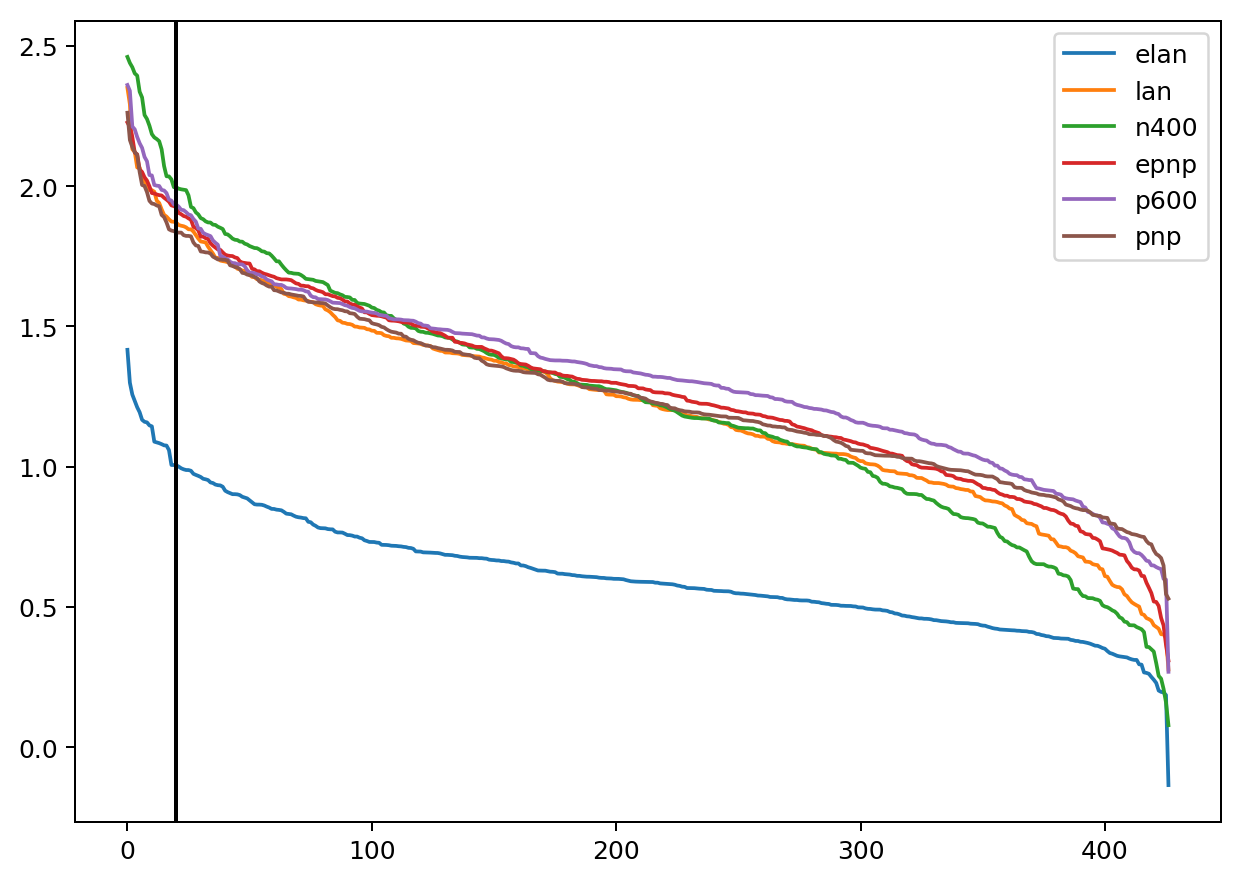

elan
Abby kneeled down to have another look in the tank that her mom had cleared so thoroughly, but Mr. Sticky was still nowhere to be found. [1.4165550470352173] sentential_co_ordination:1, object_relative_clause_non_restrictive:1
I then sat down on the floor and brushed away the hair that had accumulated on my shiny new Buster Brown shoes. [1.2993439435958862] non_local_verb_phrase_conjunction:1, source_relative_clause_non_restrictive:1
In response, the matron walked over to a little man sitting in an office chair that squeaked as it rolled around the floor and spoke to him. [1.257082462310791] non_local_verb_phrase_conjunction:1, source_relative_clause_non_restrictive:1, prepositional_phrase_attachment_ambiguity:1, gerund_modifier:1
Together they plunged into a mountain brook, which came foaming and dashing along, leaping over rocks and rushing down the hillside, until in the valley below they heard the strangest clattering noise. [1.2341972589492798] non_local_verb_phrase_conjuncti

In [53]:
max_erp_scored = score_sentences(sentence_outputs, 'natural_stories', max_erp_values, value_from='prediction')
render_subplot_artists(
    [SubplotArtist(width=7, height=5, render_fn=lambda ax: plot_scores(ax, max_erp_scored))], 
    dpi=180, is_tight_layout=True)
        
write_top_k('natural_stories', max_erp_scored, token_to_coding=token_key_to_coding)
coding_counts = top_k_coding_counts('natural_stories', token_key_to_coding, max_erp_scored, k=20)
for name in coding_counts:
    print(name)
    print(coding_counts[name])
    print('')
    print('')

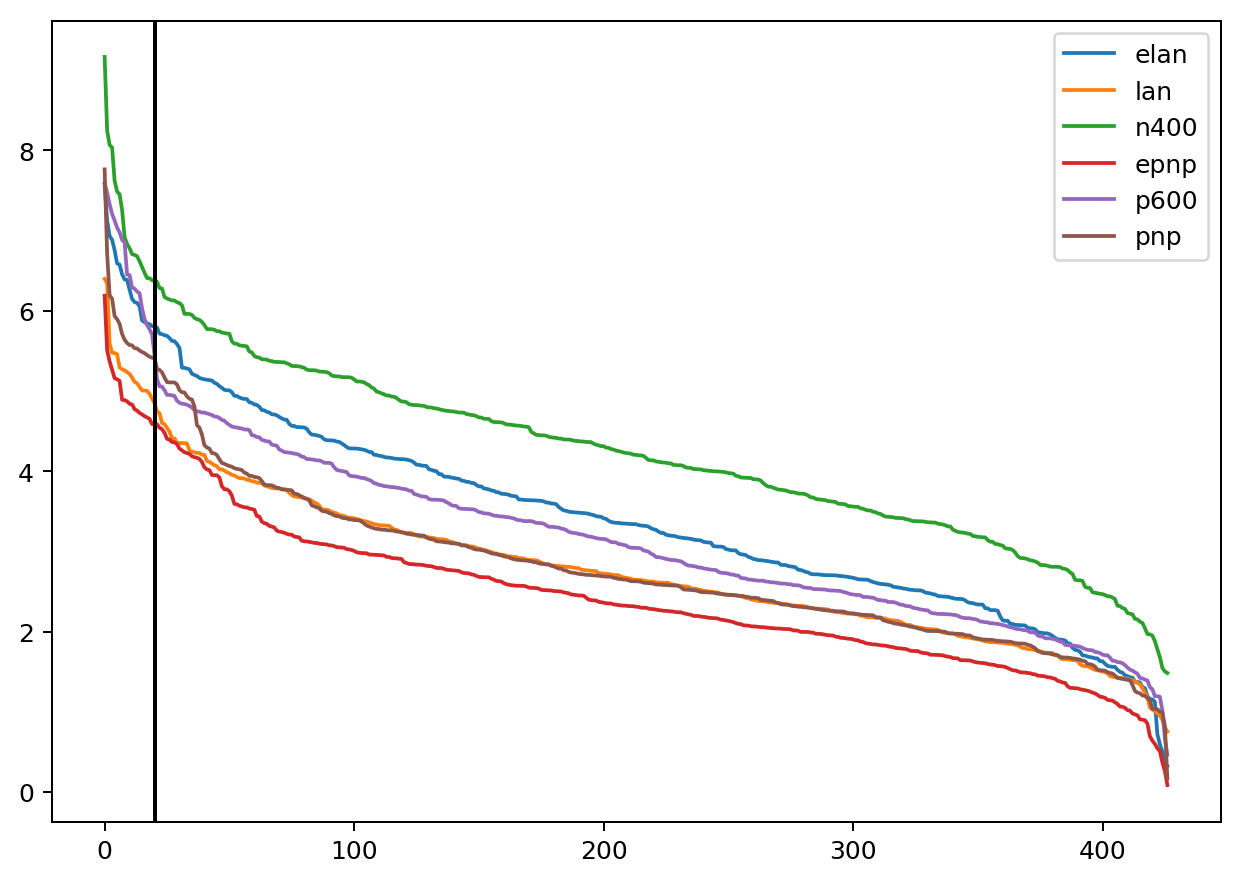

elan
That all mill owners were generally busy as beavers and quite pleased with themselves for being so successful and well off was known to the residents of Bradford, and if you were to go into the city to visit the stately City Hall, you would see there the Crest of the City of Bradford, which those same mill owners created to celebrate their achievements. [7.577284455299377] adjective_conjunction:2, object_relative_clause_non_restrictive:1, non_local_subject_verb:1, sentential_subject:1, if_then_construction:1, as_as_construction:1
Lucy did not know who it was that was sending her the messages, and she did not know how they had got her number, but whoever it was, he or she had slowly taken over Lucy's life. [7.12470243871212] sentential_co_ordination:1, complementizer_phrase_conjunctions:1, source_relative_clause_restrictive:1, object_relative_clause_restrictive:1, adverbial_relative_clause:1, free_relative_clause:3, it_cleft:1
The sun understood Aqua's request came from his heart, 

In [54]:
max_erp_scored = score_sentences(sentence_outputs, 'natural_stories', max_diff_erp, value_from='prediction')
render_subplot_artists(
    [SubplotArtist(width=7, height=5, render_fn=lambda ax: plot_scores(ax, max_erp_scored))], 
    dpi=180, is_tight_layout=True)
        
write_top_k('natural_stories', max_erp_scored, token_to_coding=token_key_to_coding)
coding_counts = top_k_coding_counts('natural_stories', token_key_to_coding, max_erp_scored, k=20)
for name in coding_counts:
    print(name)
    print(coding_counts[name])
    print('')
    print('')